# 🌊 HydroPipeline: Resilient Hydrological Data Ingestion (ANA/SNIRH)

**Author:** Ana Paula Leão | **Tech Stack:** Python, Pandas, Azure Blob Storage, HydroBr, OOP, Retry Pattern

---

## 📋 About the Project
This project implements an **End-to-End Data Engineering (ETL) pipeline** for the automated and resilient extraction of historical time-series data from the Brazilian National Water Agency (ANA).

The focus is monitoring the **Miranda River Basin (Pantanal Biome)**, a critical region subject to extreme drought and flood events. The solution was architected to overcome public API instabilities, ensuring data integrity for downstream predictive modeling (LSTM/Deep Learning).

## ⚙️ Architecture & Technical Decisions
To elevate the solution beyond basic scripting, the following patterns were adopted:
* **Object-Oriented Programming (OOP):** Encapsulation of Extraction and Loading logic.
* **Resilience:** Implementation of `Retry` decorators with *exponential backoff* to handle network failures.
* **Hybrid Storage:** Data is persisted both locally (Bronze Layer) and in the Cloud (**Azure Blob Storage**).
* **Idempotency:** The pipeline can be re-run multiple times without corrupting the Data Lake structure.

In [13]:
!pip install matplotlib hydrobr azure-storage-blob

import hydrobr
import pandas as pd
import logging
import time
import os
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import List, Callable, Dict, Optional
from functools import wraps
from azure.storage.blob import BlobServiceClient

# Configure Logging to English format
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
# --- 1. CONFIGURATION ---
@dataclass(frozen=True)
class PipelineConfig:
    """
    Immutable Configuration for the ETL Pipeline.
    Centralizes all parameters to avoid hardcoded values in logic.
    """
    flow_stations: List[str]
    rain_stations: List[str]
    raw_path: Path

    # Thesis Timeframe (Business Rule)
    start_date: str = '1994-02-01'
    end_date: str = '2024-01-31'

    # Cloud Configuration (Azure)
    # In production, fetch this from os.getenv('AZURE_CONN_STRING')
    azure_conn_string: Optional[str] = None
    azure_container_name: str = "hidropipeline-raw"

    # Resilience Settings
    max_retries: int = 3
    retry_delay_seconds: int = 5

# --- 2. RESILIENCE DECORATOR ---
def retry_with_backoff(max_attempts: int, delay: int):
    """
    Decorator to retry failed operations with a delay.
    Crucial for handling intermittency in external public APIs.
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(1, max_attempts + 1):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    logging.warning(f"⚠️ Attempt {attempt}/{max_attempts} failed for '{func.__name__}': {e}")
                    if attempt == max_attempts:
                        logging.error(f"❌ All {max_attempts} attempts failed. Pipeline aborted.")
                        raise
                    time.sleep(delay)
        return wrapper
    return decorator

# --- 3. EXTRACTION LAYER ---
class ANAExtractor:
    """
    Handles communication with the National Water Agency (ANA) API.
    Follows Single Responsibility Principle (SRP): only fetches data.
    """
    def __init__(self, config: PipelineConfig):
        self.config = config
        self._setup_environment()

    def _setup_environment(self):
        """Ensures local directory structure exists (Idempotency)."""
        (self.config.raw_path / "flow").mkdir(parents=True, exist_ok=True)
        (self.config.raw_path / "rainfall").mkdir(parents=True, exist_ok=True)

    @retry_with_backoff(max_attempts=3, delay=5)
    def _fetch_from_api(self, fetch_func, codes: List[str], data_type_name: str) -> pd.DataFrame:
        """Generic method protected by retry logic to call the library."""
        logging.info(f"📡 Starting download for {len(codes)} {data_type_name} stations...")
        df = fetch_func(codes)

        if df is None or df.empty:
            logging.warning(f"⚠️ API returned empty data for {data_type_name}.")
        else:
            logging.info(f"✅ Success: Retrieved {len(df)} records for {data_type_name}.")
        return df

    def run_flow_extraction(self) -> Optional[pd.DataFrame]:
        """Extracts Fluviometric Data (River Discharge)."""
        return self._fetch_from_api(
            fetch_func=hydrobr.get_data.ANA.flow_data,
            codes=self.config.flow_stations,
            data_type_name="FLOW"
        )

    def run_rain_extraction(self) -> Optional[pd.DataFrame]:
        """Extracts Pluviometric Data (Rainfall)."""
        return self._fetch_from_api(
            fetch_func=hydrobr.get_data.ANA.prec_data,
            codes=self.config.rain_stations,
            data_type_name="RAINFALL"
        )

# --- 4. LOADING LAYER ---
class DataLoader:
    """
    Handles data persistence strategy (Local Disk + Cloud Storage).
    Decouples I/O logic from Business logic.
    """
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.blob_service_client = None

        # Initialize Azure Client if connection string is present
        if self.config.azure_conn_string:
            try:
                self.blob_service_client = BlobServiceClient.from_connection_string(self.config.azure_conn_string)
                logging.info("☁️ Azure Blob Storage client initialized.")
            except Exception as e:
                logging.error(f"⚠️ Failed to connect to Azure: {e}")

    def _filter_by_date(self, df: pd.DataFrame) -> pd.DataFrame:
        """Applies business rules: Filters data based on Thesis timeframe."""
        if df is None or df.empty:
            return df

        logging.info(f"✂️ Filtering data between {self.config.start_date} and {self.config.end_date}...")
        return df.loc[self.config.start_date : self.config.end_date]

    def save_data(self, df: pd.DataFrame, folder_name: str, filename: str):
        if df is None or df.empty:
            logging.warning(f"⏩ No data to save for {filename}.")
            return

        # 1. Transformation (Filter)
        df_filtered = self._filter_by_date(df)

        # 2. Local Save (Bronze Layer)
        local_path = self.config.raw_path / folder_name
        full_local_path = local_path / filename
        df_filtered.to_csv(full_local_path)
        logging.info(f"💾 [LOCAL] File saved: {full_local_path} ({len(df_filtered)} rows)")

        # 3. Cloud Upload (Azure)
        if self.blob_service_client:
            try:
                blob_client = self.blob_service_client.get_blob_client(
                    container=self.config.azure_container_name,
                    blob=f"{folder_name}/{filename}"
                )
                logging.info(f"☁️ [AZURE] Uploading to container '{self.config.azure_container_name}'...")
                blob_client.upload_blob(df_filtered.to_csv(index=True), overwrite=True)
                logging.info(f"✅ [AZURE] Upload success: {folder_name}/{filename}")
            except Exception as e:
                logging.error(f"❌ [AZURE] Upload failed: {e}")

## 🚀 Pipeline Execution & Orchestration
The block below initializes the configuration with the specific stations for the **Miranda River** (MS, Brazil) and triggers the extraction processes.

In [16]:
# --- ORCHESTRATION ---

# Note: Ideally, use os.getenv("AZURE_CONN_STR") for security.
# For this portfolio demo, ensure the string is valid before running.
AZURE_CONNECTION_STRING = "SUA_CONNECTION_STRING_AQUI"

config = PipelineConfig(
    flow_stations=['66945000', '66941000', '66926000'],
    rain_stations=['1954002', '2054005', '2054019'],
    raw_path=Path("./data/raw"),
    start_date='1994-02-01',
    end_date='2024-01-31',
    azure_conn_string=AZURE_CONNECTION_STRING
)

extractor = ANAExtractor(config)
loader = DataLoader(config)

print("\n--- 🌎 STARTING HYBRID PIPELINE (LOCAL + AZURE) ---")

# Flow Pipeline
df_flow = extractor.run_flow_extraction()
loader.save_data(df_flow, "flow", "thesis_flow_data.csv")

# Rainfall Pipeline
df_rain = extractor.run_rain_extraction()
loader.save_data(df_rain, "rainfall", "thesis_rainfall_data.csv")

--- INICIANDO INGESTÃO DE VAZÃO ---


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/hydrobr/get_data.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)
 33%|███▎      | 1/3 [00:03<00:06,  3.45s/it]/usr/local/lib/python3.12/dist-packages/hydrobr/get_data.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)
 67%|██████▋   | 2/3 [00:06<00:02,  2.99s/it]/usr/local/lib/python3.12/dist-packages/hydrobr/get_data.py:177: FutureWarning: The behavior of DataFrame concate


--- INICIANDO INGESTÃO DE CHUVA ---


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/hydrobr/get_data.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)
 33%|███▎      | 1/3 [00:03<00:07,  3.98s/it]/usr/local/lib/python3.12/dist-packages/hydrobr/get_data.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)
100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


## 📊 Visual Validation & Hydrological Consistency

Following raw data ingestion, a visual inspection of the time series is performed. This step is critical within the Data Engineering pipeline to ensure:

1.  **Data Integrity:** Confirming that the raw CSV files are populated and not corrupted.
2.  **Consistency:** Verifying if river discharge patterns align with the expected hydrological seasonality of the **Miranda River Basin**.
3.  **Completeness:** Visually identifying significant data gaps that will require imputation or handling during the **Silver Layer** processing.

The plot below displays the daily discharge ($m^3/s$) for the monitored stations across the entire available historical timeframe.


📈 Generating Hydrological Dashboard...


KeyboardInterrupt: 

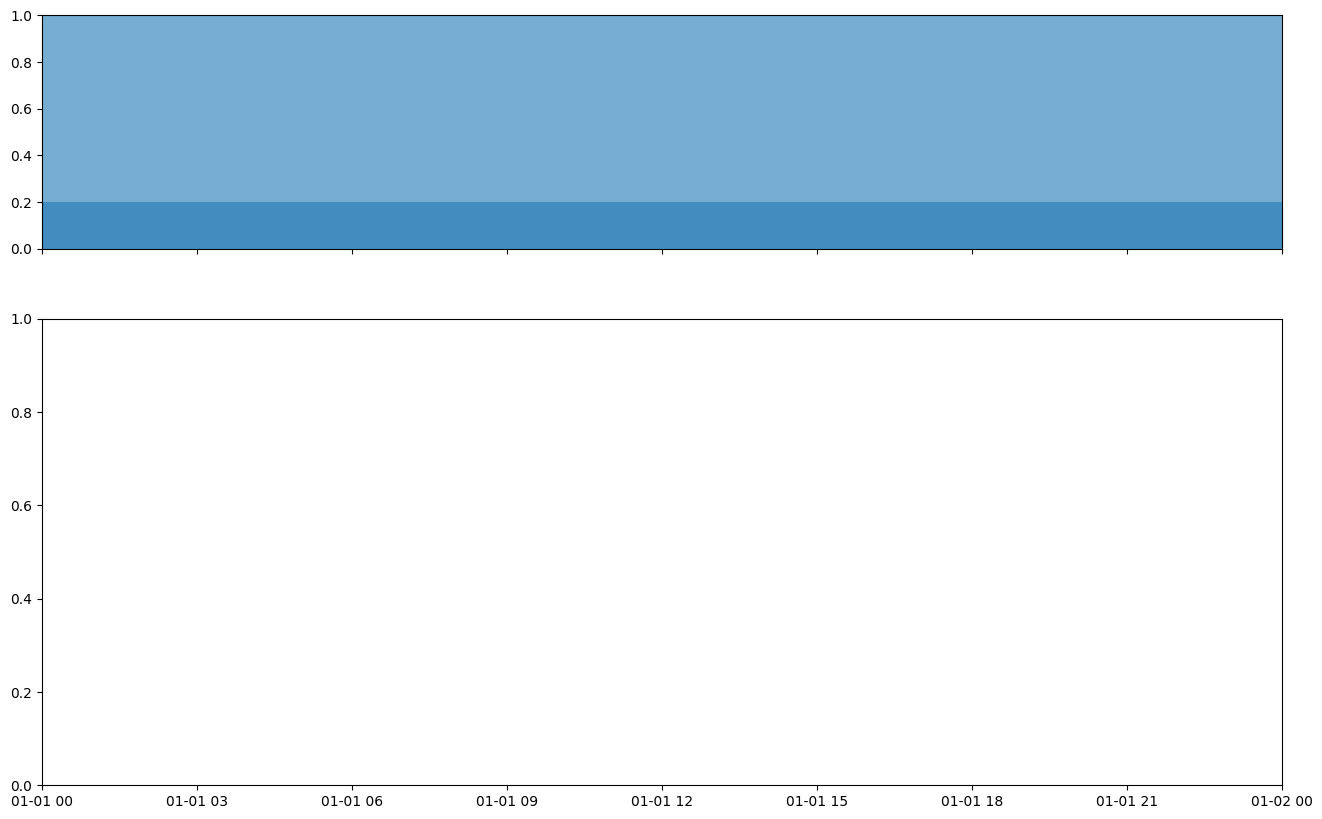

In [19]:
# --- VISUAL VALIDATION (DASHBOARD) ---
has_flow = 'df_flow' in locals() and df_flow is not None and not df_flow.empty
has_rain = 'df_rain' in locals() and df_rain is not None and not df_rain.empty

if has_flow or has_rain:
    print("\n📈 Generating Hydrological Dashboard...")

    # Create figure with 2 subplots sharing X-axis
    fig, (ax_rain, ax_flow) = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True,
                                           gridspec_kw={'height_ratios': [1, 2]})

    # Plot 1: Rainfall (Inverted Y-axis is standard in Hydrology)
    if has_rain:
        for col in df_rain.columns[:3]:
            ax_rain.bar(df_rain.index, df_rain[col], label=f"Station {col}", alpha=0.6, width=2)

        ax_rain.set_ylabel("Precipitation (mm)", fontsize=12)
        ax_rain.set_title("Hyetograph (Rain) & Hydrograph (Flow) - Historical Data", fontsize=14, fontweight='bold')
        ax_rain.legend(loc='upper right')
        ax_rain.grid(True, linestyle=':', alpha=0.6)
        ax_rain.invert_yaxis()
    else:
        ax_rain.text(0.5, 0.5, "Rainfall Data Unavailable", ha='center', va='center')

    # Plot 2: River Flow
    if has_flow:
        for col in df_flow.columns[:3]:
            ax_flow.plot(df_flow.index, df_flow[col], label=f"Station {col}", linewidth=1.2)

        ax_flow.set_ylabel("Discharge ($m^3/s$)", fontsize=12)
        ax_flow.set_xlabel("Hydrological Year", fontsize=12)
        ax_flow.legend(loc='upper right')
        ax_flow.grid(True, which='major', linestyle='--', alpha=0.7)
        ax_flow.minorticks_on()
        ax_flow.grid(True, which='minor', linestyle=':', alpha=0.3)
    else:
        ax_flow.text(0.5, 0.5, "Flow Data Unavailable", ha='center', va='center')

    plt.tight_layout()
    plt.show()
    print("✅ Dashboard generated successfully.")
else:
    print("⚠️ No data available for plotting.")